In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("digit_recognizor.csv")

In [3]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

X.shape #very very high dimensions: 784

(42000, 784)

## 1. Feature_Selection: Filters (if large feature and data - pre-selected)

#### All feature --> Best sub-features-set --> Algorithem --> Model Performance

### 1.1 VarianceThreshold:
small variance between features means they are similar distributed or types. But this is helpless when selecting samples. So the first thing we are going to do is to **remove variance = 0's features**

In [4]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold() #Instatiate, no input for parameters = default(variance = 0)
X_var0 = selector.fit_transform(X) #Gets the new feature matrix after the unqualified features are removed

In [5]:
X_var0.shape #now we have already remove all variance=0 features

(42000, 708)

We want to leave half of the features, so we can set a variance threshold that halves the total number of features, as long as we **find the median of the feature variance**, and then input this median as the value of the parameter threshold:

In [6]:
X.var().values  #X.var() is an series

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.22760590e-01, 2.64689018e+00, 1.11085714e+00, 1.92857143e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.09523810e-03, 5.41186213e-02, 1.28065733e+00, 5.33793150e+00,
       9.74592647e+00, 1.06219147e+01, 2.49289953e+01, 3.37671294e+01,
       3.59425660e+01, 3.49309575e+01, 3.62943342e+01, 3.27911079e+01,
       3.04237672e+01, 2.95547817e+01, 2.00568398e+01, 1.19545659e+01,
       8.60419724e+00, 2.55465685e+00, 1.60530842e+00, 9.29377602e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [7]:
np.median(X.var().values) # get median from the series

1352.286703180131

In [8]:
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X) #instantiate - fit_transform
X_fsvar.shape

(42000, 392)

When the feature is dichotomized, the value of the feature is Bernoulli random variable, and the variance of these variables can be calculated as: 
- **Var[x] = p(1-p)**

If the feature is Bernoulli random variable, assume p = 0.8, that is, delete the feature when some category accounts for more than 80% of the dichotomous feature

In [9]:
X_bvar = VarianceThreshold(.8 * (1 - .8)).fit_transform(X)
X_bvar.shape

(42000, 685)

### 1.2 influence of variance filtering on the model

In [10]:
#KNN vs Random Forest Performance under different variance:
from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.model_selection import cross_val_score


X = data.iloc[:,1:] 
y = data.iloc[:,0]
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

In [ ]:
#KNN: before filter
cross_val_score(KNN(),X,y,cv=5).mean() #5 folds to get mean 

%%timeit
cross_val_score(KNN(),X,y,cv=5).mean()

In [ ]:
#KNN: after filter
cross_val_score(KNN(),X_fsvar,y,cv=5).mean() #after get variance, 5 folds get mean

%%timeit
cross_val_score(KNN(),X,y,cv=5).mean()

In [15]:
#Random Forest: before filter
cross_val_score(RFC(n_estimators=10,random_state=0),X,y,cv=5).mean() #10 trees, 5 folds

0.9373571428571429

In [16]:
#Random Forest: after filter
cross_val_score(RFC(n_estimators=10,random_state=0),X_fsvar,y,cv=5).mean()

0.9390476190476191

## 2. Chi-square filter (Correlation filter)

The filtering method for discrete tags (that is, classification problem). It is characterized by a chi-square statistic from high to low. But only for **NON-Negative features** (preprocessing).

In [17]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Assume we need 300 features (K-best) at least. 
X_fschi = SelectKBest(chi2, k=300).fit_transform(X_fsvar, y) 
            #SelectKBest(method, highest k's best features)
X_fschi.shape

(42000, 300)

In [18]:
#check model performance:
cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9344761904761905

### 2.1 First way to select k: graph

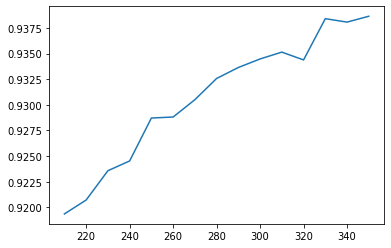

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

score = []
for i in range(350,200,-10):
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X_fsvar, y)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean() 
    score.append(once)

plt.plot(range(350,200,-10),score) 
plt.show()

### 2.2 Second way to select k : p-value

- P-value:     (<= 0.05 or 0.01)          ||    (>0.05 or 0.01)
- difference:   not form naturely ||          naturely formed (samples errors)
- correlation:  two groups data corr   ||     two groups data independent
- Null Hypothe: reject H0, accept H1     ||  Accept H0

In [21]:
chivalue, pvalues_chi = chi2(X_fsvar,y)
chivalue

array([ 945664.84392643, 1244766.05139164, 1554872.30384525,
       1834161.78305343, 1903618.94085294, 1845226.62427198,
       1602117.23307537,  708535.17489837,  974050.20513718,
       1188092.19961931, 1319151.43467036, 1397847.8836796 ,
       1433554.26798015, 1429043.15373433, 1332663.17213405,
       1101423.25372261,  809989.56940485,  519266.71772284,
        285681.88297156,  191589.23696468,  902883.1255264 ,
       1237265.16042373, 1503477.73699155, 1625807.41495542,
       1630206.90922916, 1630597.02883804, 1633456.72909664,
       1610816.75571229, 1483382.49543886, 1256290.1574794 ,
        951236.1617682 ,  693192.66191748,  532386.96220361,
        504617.38933715,  575090.36046243,  501025.03733245,
        802341.10683194, 1078344.8724406 , 1226540.98318702,
       1269945.07968831, 1221758.57688808, 1146535.17810241,
       1080657.20185303, 1079065.30979135, 1092222.70610032,
       1064908.45385716, 1023327.00231067,  974163.15420165,
        918857.12860617,

In [22]:
pvalues_chi #all 0 means all feature's p-value < 0.05. (Correlated with labels)
#so we removed more features the performace will decrease more. 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [24]:
#k should be?we want to remove all p-values > threshold，such as 0.05 or 0.01:
#Remove all p-values > 0.05 (i.e.) 
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
k

392

In [ ]:
#X_fschi = SelectKBest(chi2, k=after selected K).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

## F-Score: (ANOVA, or homogeneity test of variance)

A filtering method to capture the linear relationship between each feature and the label. It can do either regression(**feature_selection.f_regression**) with continuous data or classification(**feature_selection.f_classif**) with discrete data. Both need to work with **SelectKBest**. 

In [25]:
from sklearn.feature_selection import f_classif

F, pvalues_f = f_classif(X_fsvar, y)

F

array([ 618.65383492,  846.18897012, 1115.40617051, 1362.3677305 ,
       1452.03355369, 1381.09095571, 1138.26505266,  464.29616121,
        660.00977785,  849.66393412, 1004.7450309 , 1124.76177588,
       1200.99190762, 1209.29489877, 1110.4944286 ,  854.66183292,
        577.52063451,  342.09729054,  178.67397866,  118.01145533,
        612.12261014,  899.40904291, 1196.17528948, 1424.49864852,
       1569.26556677, 1742.49910702, 1910.98023795, 1969.20520223,
       1731.37475948, 1295.09668012,  839.15325001,  531.97951763,
        371.82392681,  336.00820537,  378.93378743,  317.47025479,
        528.94881012,  766.40792176,  947.63168717, 1086.0472161 ,
       1177.72017709, 1253.79641973, 1344.06961068, 1507.33781169,
       1616.50454434, 1512.25864876, 1289.65180587, 1051.26276412,
        839.48869386,  680.07426932,  600.85538567,  633.55772663,
        683.96908509,  347.65867784,  452.76238211,  509.16387684,
        515.7498157 ,  532.86107778,  594.62512658,  664.18740

In [26]:
pvalues_f

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.71193533e-220,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [27]:
k = F.shape[0] - (pvalues_f > 0.05).sum()
k

392

In [ ]:
#X_fsF = SelectKBest(f_classif, k=填写具体的k).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fsF,y,cv=5).mean()

## 4. Mutual Information (if large features and data)

The mutual information method is a filtering method to **capture the arbitrary relation (including linear and nonlinear relation)** between each feature and the label. Similar to the F test, it can do both regression and classification, and contains two classes: **feature_selection.mutual_info_classif**(mutual information classification) and **feature_selection.mutual_info_regression**(mutual information regression).

The mutual information method **does not return statistics similar to p value or F value**, but returns "an estimate of the mutual information between each feature and the target", which is valued between [0,1]. A value of 0 indicates that the two variables are independent, while a value of 1 indicates that the two variables are completely correlated

In [28]:
from sklearn.feature_selection import mutual_info_classif as MIC

result = MIC(X_fsvar,y)
k = result.shape[0] - sum(result <= 0)

In [29]:
result

array([0.06690773, 0.08276022, 0.10296669, 0.11495822, 0.11286447,
       0.11006218, 0.08610862, 0.05459167, 0.06918791, 0.09548657,
       0.12412966, 0.14415369, 0.16102647, 0.16283822, 0.15698418,
       0.13107566, 0.09985111, 0.0665594 , 0.03741348, 0.02169976,
       0.06502254, 0.09723802, 0.12682552, 0.14952912, 0.18425704,
       0.20330217, 0.22496304, 0.23803915, 0.21491358, 0.17548064,
       0.14276948, 0.10059921, 0.08029142, 0.05340112, 0.04039753,
       0.03214228, 0.05479687, 0.07455185, 0.10668549, 0.11890019,
       0.13854472, 0.14664525, 0.15817837, 0.18317373, 0.1795073 ,
       0.1718024 , 0.15556841, 0.13184303, 0.11638397, 0.08885746,
       0.08594925, 0.06890449, 0.06823145, 0.05189158, 0.05842258,
       0.07236824, 0.08689894, 0.09568855, 0.10056147, 0.11017431,
       0.11106087, 0.1222357 , 0.1265652 , 0.11525575, 0.11172128,
       0.11309326, 0.1173553 , 0.1041515 , 0.08951308, 0.07662627,
       0.07202231, 0.04265491, 0.05866054, 0.06598627, 0.07846

In [30]:
k

392

In [ ]:
#X_fsmic = SelectKBest(MIC, k=填写具体的k).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fsmic,y,cv=5).mean()

## 5. Embedded: (if Logistic Regression)

The embedding method is a method that allows the algorithm to decide which features to use by itself, that is, feature selection and algorithm training are carried out at the same time.

The embedding method USES some machine learning algorithms and models for training, and obtains the weight coefficients of each feature, and selects the features from large to small according to the weight coefficients.

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC

RFC_ = RFC(n_estimators =10,random_state=0) #instantiate for RF
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y)
                        #SelectFromModel(method, remove all that small threshold)

I just want to take out a limited number of features. The 0.005 threshold is a very high threshold for data with 780 features, as each feature can be assigned to about 0.001 feature_importances_ on average

In [32]:
X_embedded.shape
# The dimension of the model has been significantly reduced
#Draw the learning curve to find the best threshold

(42000, 47)

In [35]:
RFC_.fit(X,y).feature_importances_.max()

0.01276360214820271

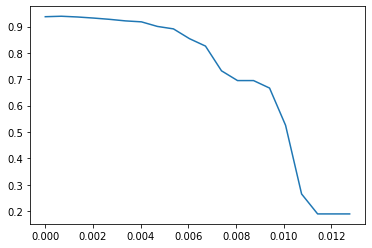

In [33]:
#curve to find threshold:

threshold = np.linspace(0,(RFC_.fit(X,y).feature_importances_).max(),20)

score = []
for i in threshold:
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y) 
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean() 
    score.append(once)

plt.plot(threshold,score) 
plt.show()

In [36]:
X_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
X_embedded.shape

(42000, 324)

In [37]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9391190476190475

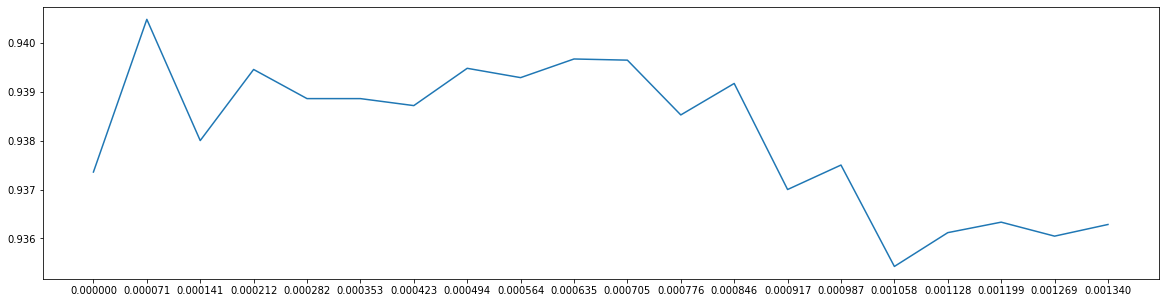

In [38]:
score2 = []
#smaller the range:
for i in np.linspace(0,0.00134,20):
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score2.append(once)
    
plt.figure(figsize=[20,5])
plt.plot(np.linspace(0,0.00134,20),score2)
plt.xticks(np.linspace(0,0.00134,20))
plt.show()

Check the result, sure enough, 0.00067 is not the highest point, the real highest point 0.000564 has improved the model effect to more than 94%. We use the 0.000564 to try again:

In [39]:
X_embedded = SelectFromModel(RFC_,threshold=0.000564).fit_transform(X,y)
X_embedded.shape

(42000, 340)

In [40]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9392857142857144

In [41]:
#We may have found the best result under the existing model. 
# What if we adjust the parameters of the random forest?
cross_val_score(RFC(n_estimators=100,random_state=0),X_embedded,y,cv=5).mean()

0.9634285714285715

## 6. Wrapped: (if SVM)

Wrapping is also a feature selection and algorithm training method at the same time, is very similar to embedding method, it also depends on the algorithm's own selection, such as coef_ attribute or feature_importances_ attribute to complete the feature selection. But the difference is that we tend to use a target function as a **black box** to help us select features, rather than enter the threshold of an evaluation indicator or statistic ourselves.

In [42]:
from sklearn.feature_selection import RFE

RFC_ = RFC(n_estimators =10,random_state=0)
selector = RFE(RFC_, n_features_to_select=340, step=50).fit(X, y)

selector.support_.sum()

340

In [43]:
selector.ranking_ #order the importance from low 1-10

array([10,  9,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  6,  6,
        5,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  5,  4,
        4,  5,  3,  4,  4,  4,  5,  4,  5,  7,  6,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  7,  4,  3,  1,  2,  3,  3,  1,  1,  1,  1,
        1,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9,  9,  9,  8,  9,  9,  4,
        4,  3,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  4,
        5,  5,  9,  9, 10, 10, 10, 10,  7,  4,  4,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  5,  8, 10, 10, 10,
       10,  9,  4,  4,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  4, 10, 10, 10, 10,  9,  7,  4,  3,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        4,  4, 10,  9, 10

In [44]:
X_wrapper = selector.transform(X)
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()

0.9379761904761905

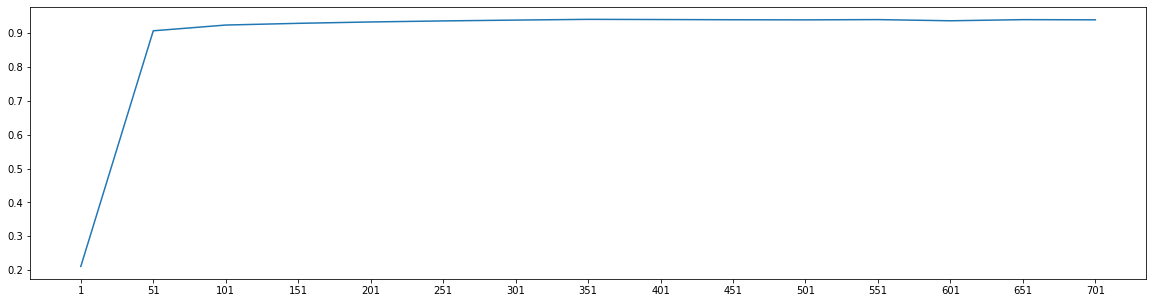

In [45]:
#learning curve: cost is less than embedded, but higher than filtering
score = []
for i in range(1,751,50):
    X_wrapper = RFE(RFC_,n_features_to_select=i, step=50).fit_transform(X,y) 
    once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
    score.append(once)

plt.figure(figsize=[20,5]) 
plt.plot(range(1,751,50),score) 
plt.xticks(range(1,751,50)) 
plt.show()

In [56]:
max(score)

0.9404047619047621